In [1]:
import numpy as np
from dwave.system import LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler

from modules.solvers import QuantumAnnealing

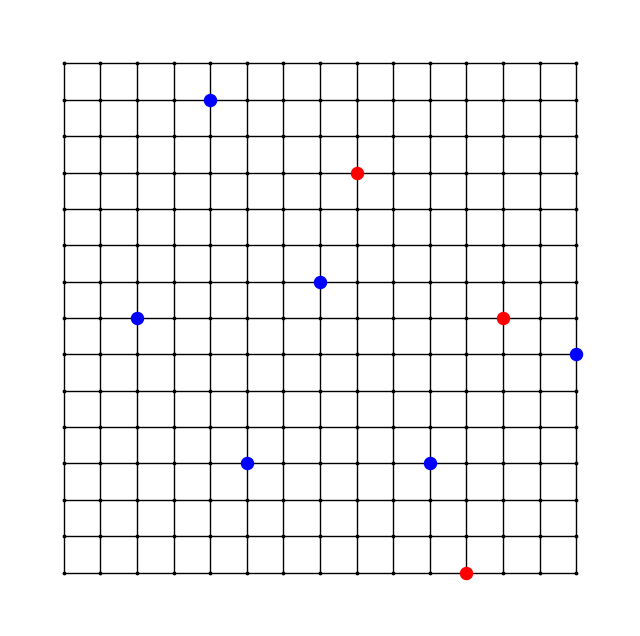

In [2]:
WIDTH = 15
HEIGHT = 15
POI = 6
CHARGERS = 3
NEW_CHARGERS = 3

qa = QuantumAnnealing(WIDTH, HEIGHT, POI, CHARGERS, NEW_CHARGERS, num_reads=100)

hyperparams = np.array([4, 3, 1.7, 3])
hyper = np.array([3.46171877, 1.85156246, 2.9017289 , 5.02177708])

qa.draw_grid()

In [3]:
# qa.

In [4]:
hyper

array([3.46171877, 1.85156246, 2.9017289 , 5.02177708])


Score:  0.4171880199504755


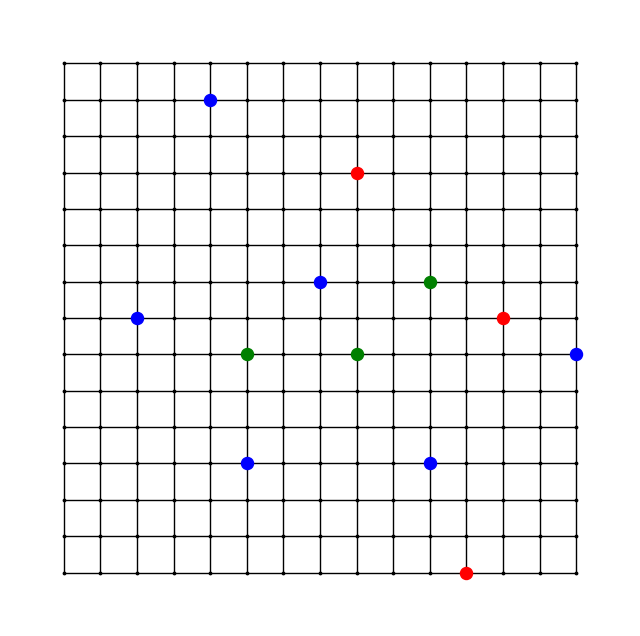

In [5]:
bqm = qa.build_bqm()
sampleset, qa.new_charging_nodes = qa.run_bqm_and_collect_solutions(bqm)

# Calculate score
score = qa.score_sampleset(sampleset)

# Create scenario output image
print("\nScore: ", score)
qa.draw_grid()